Цель: определить параметры формулы, используемой в EngineWise для коррекции

идеи: отбросить точки где нет OAT и использовать температуру 286.3

In [15]:
import pandas as pd
from sklearn.metrics import mean_absolute_error

data = pd \
  .read_csv('../takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts']) 

data.loc[data['oat'].isna(), ['oat']] = data.loc[data['oat'].isna(), :]['tat']

Columns: N1 (unbiased), N1C2 (corrected)

In [16]:
X = data[['n1a', 'n1c2']]

MAE Original:

In [17]:
mean_absolute_error(X['n1a'], X['n1c2'])

1.6565512333965846

#### Theta factor correction

In [32]:
theta = (data['oat'] + 273.15) / 288.15

alpha = 0.5

n1k = X['n1a'] / (theta ** alpha)

mean_absolute_error(n1k, X['n1c2'])

0.27838580217559816

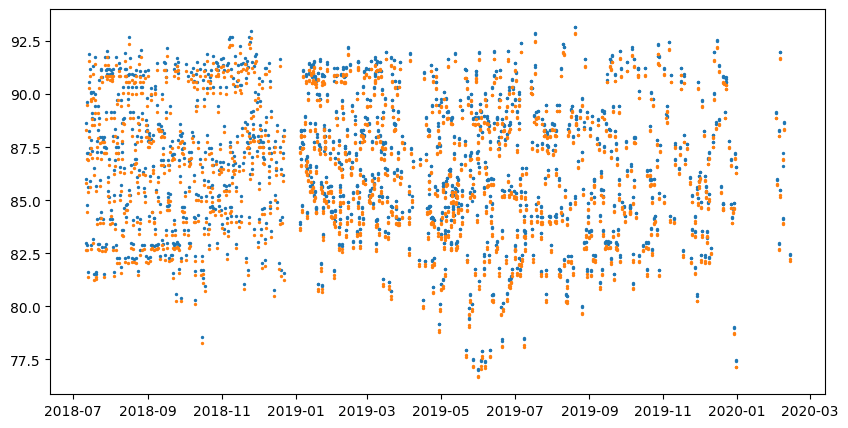

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(data['reportts'], n1k, s=2)
plt.scatter(data['reportts'], data['n1c2'], s=2)
plt.show()

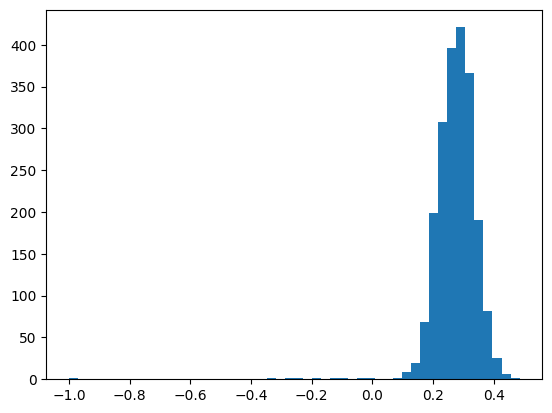

In [42]:
err = n1k - data['n1c2']
plt.hist(err, bins=50)
plt.show()

In [48]:
data['n1c2']

0       87.24
1       83.61
2       88.04
3       86.61
4       87.99
        ...  
2103    91.69
2104    83.95
2105    86.94
2106    88.37
2107    82.21
Name: n1c2, Length: 2108, dtype: float64

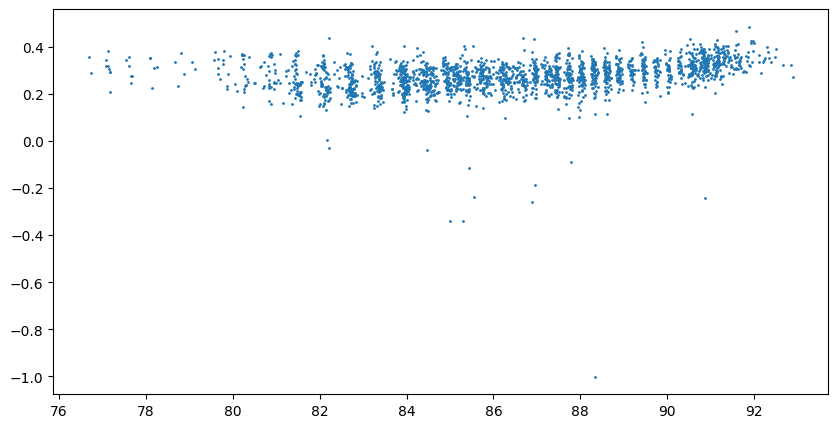

In [47]:
plt.figure(figsize=(10, 5))
plt.title('Relative error to N1C2')
plt.scatter(data['n1c2'], err, s=1)

Plot N1 (rotor speed) vs error

In [20]:
pd.DataFrame(n1k - data['n1c2']).describe()

,0
count,2108.000000
mean,0.275653
std,0.070413
min,-1.001185
25%,0.239826
50%,0.280405
75%,0.315738
max,0.484923


Now let's try to adjust alpha more closely:

In [21]:
a = 0.20
min_err = 100
min_a = a
while a <= 0.65:
  n1k = X['n1a'] / (theta ** a)
  err = mean_absolute_error(n1k, X['n1c2'])
  if err < min_err:
    min_a = a
    min_err = err
  a += 0.00001

print(f'a = {min_a} min error = {min_err}')

a = 0.46493000000026496 min error = 0.22648840607725546


In [28]:
a = 0.5
min_err = 1000
temp = 288.15 - 30
min_temp = temp
while temp <= (288.15 + 30):
  theta = (data['oat'] + 273.15) / temp
  n1k = X['n1a'] / (theta ** a)
  err = mean_absolute_error(n1k, X['n1c2'])
  if err < min_err:
    min_temp = temp
    min_err = err
  temp += 0.001

print(f'temp = {min_temp} min error = {min_err}')

temp = 286.2999999993343 min error = 0.044596635540719874


In [22]:
a = 0.5255
y_err = X['n1c2'] - (X['n1a'] / (theta ** a))